In [47]:
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.signal import hilbert
from scipy.signal.windows import tukey 
import numpy as np
import vectorised_hf as vhf

# Load just the waveform from the data file
data = scipy.io.loadmat('data/ultrasound_reflection_data.mat', variable_names=['__header__', '__version__', '__globals__', 'elementPositions', 'samplingFrequency', 'soundSpeed','waveform', 'rcvData'])
folder_path = 'data'

In [48]:
# Extract the numpy arrays from the dictionary using their variable names
samplingFrequency = data['samplingFrequency']
elementPositions = data['elementPositions']
soundSpeed = data['soundSpeed']
rcvData = data['rcvData']

Ntx, Nrx, Nt = rcvData.shape
rcvData2D = rcvData.reshape(Ntx*Nrx, Nt)
winData2D = vhf.tukey_vectorised(rcvData2D,  alpha=0.1, noise_Length=300)
test_env = vhf.envelope_detection(winData2D)

nTx = 255 # Number of transmitters
nRx = 255 # Number of receivers
nt = 2559 # Time samples
dx = 0.003  # Grid spacing
Lx = 0.12    # Size of the grid
speedOfSound = 1540  # Speed of sound in m/s (typical for soft tissues)

# Create imaging vector
Xp, Yp = vhf.createImagingVector(dx, Lx)

# Detector coordinates (example values)
Xd = elementPositions[:,0]  # X coordinates of detectors
Yd = elementPositions[:,1]  # Y coordinates of detectors

# Xd, Xp, Yd and Yp are in 1D, this means that the function cannot run, since they don't have an overlapping dimension to be multipled by
# The following code makes the 'points' 2D and transposes the matrices so that they are in the right row to column order, before running the distance map function
Xd2D = Xd.reshape(-1,1)
Xp2D = Xp.reshape(-1,1)
Yd2D = Yd.reshape(-1,1)
Yp2D = Yp.reshape(-1,1)
Yd2DT = Yd2D.T
Xd2dT = Xd2D.T
# Calculate distance map
distanceMap = vhf.calculateDistanceMap(Xd2dT, Yd2DT, Xp2D, Yp2D)
# Convert distance map to time map
timeMap = vhf.timeMap(distanceMap, speedOfSound)

# Initialise accumulator
accumulator = 0

accumulated_values = np.zeros(Xd2dT.shape)

# Plot X and Y using plt.imshow
# plt.imshow(accumulated_values)

(2560,)
256.0
256.0
167772160


In [49]:
# Make the 2D envelope back into 3D for ease of indexing
envData3D = test_env.reshape(Ntx, Nrx, Nt)

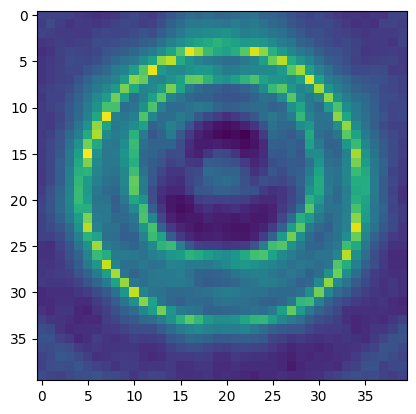

In [50]:
accumulator = np.zeros_like(Xp2D) 
for Tx in range (0,nTx,4): # All the transmiters from 0 to 255,  going up in increments of 8
    for Rx in range (nRx):
        # Masking task! 
        # Loop over all the receivers, with only 1 transmitter, the pixel has been vectorised and will not be looped over
        #  Have a 'time' from the transmitter to the pixel, then the pixel to the receiver for the total time
        T1 = timeMap[:,Tx]
        T2 = timeMap[:,Rx] 
        total_time = T1 + T2
        # Convert travel time to sample index
        sample_index = vhf.time_to_sample_index(total_time, samplingFrequency)
        sample_index = sample_index.astype(int)
        valid =  np.logical_and(sample_index < nt, sample_index >= 0)
        extract = envData3D[Tx,Rx,sample_index[valid]]  
        accumulator[valid.T]= accumulator[valid.T] + extract
        np.sum(extract)
n = np.size(accumulator)
x = int(np.sqrt(n))
finalImage = np.reshape(accumulator,(x,x))
plt.imshow(finalImage)
